In [1]:
import mxnet as mx
from mxnet import gluon, autograd, nd
from mxnet.gluon import nn,utils 
import mxnet.ndarray as F
import numpy as np
import os, sys
from tqdm import tqdm

import pickle
import random
from tqdm import tqdm

In [2]:
gpu_idx = 4 # increase if you have more
ctx = mx.gpu(gpu_idx)

In [3]:
class ConvInputModel(nn.HybridBlock):
    def __init__(self,**kwargs):
        super(ConvInputModel,self).__init__(**kwargs)
                
        with self.name_scope():
            self.conv1 = nn.Conv2D(channels=24,kernel_size=3,strides=2,padding=1,activation='relu')
            self.bn1 = nn.BatchNorm()
            self.conv2 = nn.Conv2D(channels=24,kernel_size=3,strides=2,padding=1,activation='relu')
            self.bn2 = nn.BatchNorm()
            self.conv3 = nn.Conv2D(channels=24,kernel_size=3,strides=2,padding=1,activation='relu')
            self.bn3 = nn.BatchNorm()
            self.conv4 = nn.Conv2D(channels=24,kernel_size=3,strides=2,padding=1,activation='relu')
            self.bn4 = nn.BatchNorm()
            
    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        
        return x

In [4]:
class FCOutputModel(nn.HybridBlock):
    def __init__(self,**kwargs):
        super(FCOutputModel,self).__init__(**kwargs)
        
        with self.name_scope():
            self.fc2 = nn.Dense(256)
            self.fc3 = nn.Dense(10)
    
    def forward(self,x):
        x = self.fc2(x)
        x = F.relu(x)
        x = F.Dropout(x)
        x = self.fc3(x)
        
        #return F.log_softmax(x)
        return x

In [5]:
class RN_Model(nn.HybridBlock):
    def __init__(self,args,**kwargs):
        super(RN_Model,self).__init__(**kwargs)
    
        with self.name_scope():
            self.conv = ConvInputModel()
            
            self.g_fc1 = nn.Dense(256,activation='relu')
            self.g_fc2 = nn.Dense(256,activation='relu')
            self.g_fc3 = nn.Dense(256,activation='relu')
            self.g_fc4 = nn.Dense(256,activation='relu')
            
            self.f_fc1 = nn.Dense(256,activation='relu')
            
            
            #self.coord_oi = gluon.Parameter('oi',shape=(args.batch_size,2))
            #self.coord_oj = gluon.Parameter('oj',shape=(args.batch_size,2))
            #self.coord_tensor = gluon.Parameter('coord_tensor',shape=(args['batch_size'],25,2))
        
            ##initialize
            #self.coord_oi.intialize()
            #self.coord_oj.intialize()
            #self.coord_tensor.initialize(ctx=ctx)
            
            
            
            self.fcout = FCOutputModel()
            
            

    def forward(self,x,qst):
        
        self.coord_tensor = F.zeros((args['batch_size'], 25, 2),ctx=mx.gpu(gpu_idx))
         # prepare coord tensor
        def cvt_coord(i):
                return [(i/5-2)/2., (i%5-2)/2.]
        
        for i in range(25):
            self.coord_tensor[:,i,:] = F.array( cvt_coord(i) )
        #self.coord_tensor.set_data(F.array(np_coord_tensor).copy())
        
        #input size = (64 * 3 * 75 * 75)
        x = self.conv(x) ## x = (64 * 24 * 5 * 5)
                
        ##g part
        mb = x.shape[0]
        n_channels = x.shape[1]
        d = x.shape[2]
        
        x_flat = x.reshape(shape=(mb,n_channels,d*d))
        x_flat = F.swapaxes(x_flat,1,2) ## (64 * 25 * 24)
        
        ##add coordinates
        x_flat = F.concat(x_flat,self.coord_tensor,dim=2) ##(64 * 25 * 26)
        #x_flat = F.concat(x_flat,np_coord_tensor,dim=2)
        
        ##add question
        qst = qst.expand_dims(1)
        qst = F.repeat(qst,repeats=25,axis=1)
        qst =qst.expand_dims(2)
        
        # cast all pairs against each other
        x_i = x_flat.expand_dims(1)
        x_i = F.repeat(x_i,repeats=25,axis=1)
        
        x_j = x_flat.expand_dims(2)
        x_j = F.concat(x_j,qst,dim=3)
        x_j = F.repeat(x_j,repeats=25,axis=2)
        
        #concatenate all
        x_full = F.concat(x_i,x_j,dim=3)
        
        #reshape and apply dnn network
        x_ = x_full.reshape((-1,63))
        x_ = self.g_fc1(x_)
        x_ = self.g_fc2(x_)
        x_ = self.g_fc3(x_)
        x_ = self.g_fc4(x_)
        
        x_g = x_.reshape((mb,-1,256))
        x_g = x_g.sum(1)
        
        ##### f part #######
        x_f = self.f_fc1(x_g)
        
        return self.fcout(x_f)
            

In [6]:
def load_data():
    print('loading data...')
    dirs = os.getcwd()
    filename = os.path.join(dirs,'sort-of-clevr.pickle')
    with open(filename, 'rb') as f:
        train_datasets, test_datasets = pickle.load(f)
    rel_train = []
    rel_test = []
    norel_train = []
    norel_test = []
    print('processing data...')

    for img, relations, norelations in train_datasets:
        img = np.swapaxes(img,0,2)
        for qst,ans in zip(relations[0], relations[1]):
            rel_train.append((img,qst,ans))
        for qst,ans in zip(norelations[0], norelations[1]):
            norel_train.append((img,qst,ans))

    for img, relations, norelations in test_datasets:
        img = np.swapaxes(img,0,2)
        for qst,ans in zip(relations[0], relations[1]):
            rel_test.append((img,qst,ans))
        for qst,ans in zip(norelations[0], norelations[1]):
            norel_test.append((img,qst,ans))
    
    return (rel_train, rel_test, norel_train, norel_test)

In [7]:
rel_train, rel_test, norel_train, norel_test = load_data()

loading data...
processing data...


In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [9]:
def display_image(data):
    img = data[0]
    img = np.swapaxes(img,0,2)
    plt.imshow((img * 255.0).astype('uint8'))

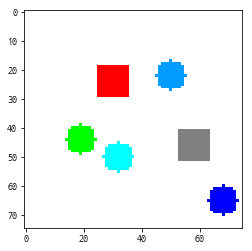

In [10]:
display_image(rel_train[11])

In [11]:
args = dict()
args['batch_size'] = 64
args['epoches'] = 30

In [12]:
model = RN_Model(args)

In [13]:
#parameter initialozation
model.collect_params().initialize(ctx=ctx)

In [14]:
#set optimizer
trainer = gluon.Trainer(model.collect_params(),optimizer='adam',optimizer_params={'learning_rate':0.0001})

In [15]:
#define loss function
loss = gluon.loss.SoftmaxCrossEntropyLoss()

In [16]:
def cvt_data_axis(data):
    img = [e[0] for e in data]
    qst = [e[1] for e in data]
    ans = [e[2] for e in data]
    return (img,qst,ans)

In [17]:
def ndarray_conv(data, i,bs,ctx):
    img = F.array(np.asarray(data[0][bs*i:bs*(i+1)]),ctx=ctx)
    qst = F.array(np.asarray(data[1][bs*i:bs*(i+1)]),ctx=ctx)
    ans = F.array(np.asarray(data[2][bs*i:bs*(i+1)]),ctx=ctx)

    return img, qst, ans

In [18]:
#Define Evaluation metric
def evaluate_accuracy(data,  model, ctx):
    data_conv = cvt_data_axis(data)
    acc = mx.metric.Accuracy()
    accuracy_mat = []
    for batch_idx in range(len(data) // (args['batch_size'])):
        input_img, input_qst, label = ndarray_conv(data_conv,batch_idx,args['batch_size'],ctx)
        output = model(input_img,input_qst)
        predictions = nd.argmax(output,axis=1)
        acc.update(preds=predictions, labels=label)
        accuracy_mat.append(acc.get()[1])
    accuracy = sum(accuracy_mat) / len(accuracy_mat)
    return accuracy

In [19]:
for epoch in tqdm(range(args['epoches'])):
    cumulative_rel_loss = 0.0
    cumulative_norel_loss = 0.0
    
    input_rel_train = rel_train.copy()
    input_norel_train = norel_train.copy()
    
    #shuffle data
    random.shuffle(input_rel_train)
    random.shuffle(input_norel_train)
    
    rel = cvt_data_axis(input_rel_train)
    norel = cvt_data_axis(input_norel_train)
    
    for batch_idx in range(len(rel[0]) // (args['batch_size'])):
        input_rel_img, input_rel_qst, rel_label = ndarray_conv(rel,batch_idx,args['batch_size'],ctx)
        
        with autograd.record():
            rel_output = model(input_rel_img,input_rel_qst)
            rel_loss = loss(rel_output,rel_label)
        rel_loss.backward()
        trainer.step(args['batch_size'])
        cumulative_rel_loss += nd.sum(rel_loss).asscalar()
        
        input_norel_img, input_norel_qst, norel_label = ndarray_conv(norel,batch_idx,args['batch_size'],ctx)  
        with autograd.record():
            norel_output = model(input_norel_img,input_norel_qst)
            norel_loss = gluon.loss.SoftmaxCrossEntropyLoss()(norel_output,norel_label)
        norel_loss.backward()
        trainer.step(args['batch_size'])
        cumulative_norel_loss += nd.sum(norel_loss).asscalar()
        
    rel_accuracy = evaluate_accuracy(rel_test, model, ctx)
    norel_accuracy = evaluate_accuracy(norel_test, model, ctx)
    #print("Epoch {e}. rel_Loss: {rl} ".format(e=epoch, rl=cumulative_loss/(len(rel[0]) // (args['batch_size']))))
    print("Epoch {e}. rel_Loss: {rl} norel_Loss: {nrl} rel_ACC: {rl_acc} norel_ACC: {nrl_acc}".format(e=epoch, rl=cumulative_rel_loss/(len(rel[0]) // args['batch_size'])
                                                                                                      , nrl=cumulative_norel_loss/ (len(rel[0]) // args['batch_size']), rl_acc=rel_accuracy,nrl_acc=norel_accuracy))

  3%|▎         | 1/30 [01:36<46:46, 96.77s/it]

Epoch 0. rel_Loss: 60.893042618585206 norel_Loss: 46.403109995856305 rel_ACC: 0.644911047027514 norel_ACC: 0.5670214128330142


  7%|▋         | 2/30 [03:12<45:02, 96.50s/it]

Epoch 1. rel_Loss: 42.143365450110956 norel_Loss: 42.378515830310945 rel_ACC: 0.6781246940256477 norel_ACC: 0.5436258549422645


 10%|█         | 3/30 [04:48<43:20, 96.31s/it]

Epoch 2. rel_Loss: 39.070834915440194 norel_Loss: 41.947911479907596 rel_ACC: 0.6041821044890893 norel_ACC: 0.6046974678016904


 13%|█▎        | 4/30 [06:26<41:56, 96.80s/it]

Epoch 3. rel_Loss: 37.8697338166539 norel_Loss: 41.59693840918862 rel_ACC: 0.6971469828077164 norel_ACC: 0.59409828421267


 17%|█▋        | 5/30 [08:03<40:19, 96.78s/it]

Epoch 4. rel_Loss: 37.16387513258503 norel_Loss: 41.38369719332764 rel_ACC: 0.6858356531643962 norel_ACC: 0.6037202684543874


 20%|██        | 6/30 [09:39<38:41, 96.73s/it]

Epoch 5. rel_Loss: 36.418964518043126 norel_Loss: 41.1787999911218 rel_ACC: 0.6907515301073822 norel_ACC: 0.6173677368478866


 23%|██▎       | 7/30 [11:13<36:44, 95.85s/it]

Epoch 6. rel_Loss: 35.80957102261674 norel_Loss: 41.037380153723284 rel_ACC: 0.4526636644662829 norel_ACC: 0.5843627877823574


 27%|██▋       | 8/30 [12:46<34:50, 95.02s/it]

Epoch 7. rel_Loss: 35.76402726973839 norel_Loss: 40.93745163731292 rel_ACC: 0.682895839084865 norel_ACC: 0.6281480997001231


 30%|███       | 9/30 [14:20<33:05, 94.54s/it]

Epoch 8. rel_Loss: 35.09499647039591 norel_Loss: 40.78940554867376 rel_ACC: 0.6930243255611401 norel_ACC: 0.6157892599453609


 33%|███▎      | 10/30 [15:54<31:27, 94.37s/it]

Epoch 9. rel_Loss: 35.068792082763515 norel_Loss: 40.654852153895185 rel_ACC: 0.7050078473135845 norel_ACC: 0.6237111940134058


 37%|███▋      | 11/30 [17:27<29:47, 94.09s/it]

Epoch 10. rel_Loss: 34.45732533674782 norel_Loss: 40.50836941340949 rel_ACC: 0.7153887958405648 norel_ACC: 0.6330182608120702


 40%|████      | 12/30 [19:01<28:14, 94.11s/it]

Epoch 11. rel_Loss: 34.28848905831205 norel_Loss: 39.979220369763816 rel_ACC: 0.7244517980134796 norel_ACC: 0.6555851352146868


 43%|████▎     | 13/30 [20:34<26:34, 93.80s/it]

Epoch 12. rel_Loss: 34.03899449448738 norel_Loss: 33.04881597141438 rel_ACC: 0.6871982450178838 norel_ACC: 0.8033757055754795


 47%|████▋     | 14/30 [22:09<25:05, 94.10s/it]

Epoch 13. rel_Loss: 33.08391691515603 norel_Loss: 21.230693239078732 rel_ACC: 0.7375869482910165 norel_ACC: 0.8738013557232153


 50%|█████     | 15/30 [23:42<23:24, 93.64s/it]

Epoch 14. rel_Loss: 29.219723887726968 norel_Loss: 14.129230334196583 rel_ACC: 0.7097258786288441 norel_ACC: 0.9237007898928189


 53%|█████▎    | 16/30 [25:15<21:48, 93.43s/it]

Epoch 15. rel_Loss: 25.972523863684657 norel_Loss: 5.446856615961494 rel_ACC: 0.8208384585581795 norel_ACC: 0.9838696777521365


 57%|█████▋    | 17/30 [26:49<20:17, 93.66s/it]

Epoch 16. rel_Loss: 23.600671994304594 norel_Loss: 1.9756318964045871 rel_ACC: 0.8356744533371067 norel_ACC: 0.9893192080477562


 60%|██████    | 18/30 [28:23<18:46, 93.90s/it]

Epoch 17. rel_Loss: 22.0311200642103 norel_Loss: 1.330527506059414 rel_ACC: 0.8578030324669422 norel_ACC: 0.9839485577764762


 63%|██████▎   | 19/30 [29:57<17:12, 93.89s/it]

Epoch 18. rel_Loss: 20.269255728444424 norel_Loss: 0.9753381701020231 rel_ACC: 0.8584965748631254 norel_ACC: 0.9919755317355601


 67%|██████▋   | 20/30 [31:30<15:37, 93.75s/it]

Epoch 19. rel_Loss: 18.924349501115834 norel_Loss: 0.778562094882565 rel_ACC: 0.8574065294991291 norel_ACC: 0.9900599997317426


 70%|███████   | 21/30 [33:04<14:02, 93.62s/it]

Epoch 20. rel_Loss: 17.520323550911375 norel_Loss: 0.6506747916388124 rel_ACC: 0.8699601075516599 norel_ACC: 0.9947022248002668


 73%|███████▎  | 22/30 [34:38<12:29, 93.69s/it]

Epoch 21. rel_Loss: 16.389930070731314 norel_Loss: 0.5393892024495025 rel_ACC: 0.8671745844875021 norel_ACC: 0.9905175595443768


 77%|███████▋  | 23/30 [36:10<10:53, 93.41s/it]

Epoch 22. rel_Loss: 15.407217384864115 norel_Loss: 0.4928368747507637 rel_ACC: 0.8723874135682871 norel_ACC: 0.9912690005947838


 80%|████████  | 24/30 [37:43<09:19, 93.18s/it]

Epoch 23. rel_Loss: 14.49431818096876 norel_Loss: 0.4151209252528118 rel_ACC: 0.882819099522611 norel_ACC: 0.9949190858181164


 83%|████████▎ | 25/30 [39:17<07:47, 93.51s/it]

Epoch 24. rel_Loss: 13.715022791919173 norel_Loss: 0.3518597316184891 rel_ACC: 0.8958902744579345 norel_ACC: 0.9910266718343536


 87%|████████▋ | 26/30 [40:52<06:15, 93.81s/it]

Epoch 25. rel_Loss: 12.940758954302927 norel_Loss: 0.33900085693208976 rel_ACC: 0.8986703625673379 norel_ACC: 0.9945220502453951


 90%|█████████ | 27/30 [42:26<04:41, 93.87s/it]

Epoch 26. rel_Loss: 12.14070699777111 norel_Loss: 0.2956663809945092 rel_ACC: 0.8907945339653153 norel_ACC: 0.9946423362502359


 93%|█████████▎| 28/30 [44:00<03:07, 93.93s/it]

Epoch 27. rel_Loss: 11.320969343029697 norel_Loss: 0.30255659231845544 rel_ACC: 0.8942954739157147 norel_ACC: 0.9986678913991329


 97%|█████████▋| 29/30 [45:35<01:34, 94.19s/it]

Epoch 28. rel_Loss: 10.770466038014357 norel_Loss: 0.28003496032806385 rel_ACC: 0.8653015925210129 norel_ACC: 0.99613278934671


100%|██████████| 30/30 [47:08<00:00, 94.01s/it]

Epoch 29. rel_Loss: 10.006709086824912 norel_Loss: 0.2696463917596134 rel_ACC: 0.8894645468368334 norel_ACC: 0.9982114652980479


In [20]:
model

RN_Model(
  (conv): ConvInputModel(
    (conv1): Conv2D(3 -> 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, in_channels=24)
    (conv2): Conv2D(24 -> 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, in_channels=24)
    (conv3): Conv2D(24 -> 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, in_channels=24)
    (conv4): Conv2D(24 -> 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, in_channels=24)
  )
  (g_fc1): Dense(63 -> 256, Activation(relu))
  (g_fc2): Dense(256 -> 256, Activation(relu))
  (g_fc3): Dense(256 -> 256, Activation(relu))
  (g_fc4): Dense(256 -> 256, Activation(relu))
  (f_fc1): Dense(256 -> 256, Activation(relu))
  (fcout): FCOutputModel(
    (fc2): Dense(256 -> 256, 

In [21]:
os.getcwd()

'/home/skinet/work/dl_study'

In [23]:
##save the model
filename = os.getcwd()+'/models/rl_single_gpu.params'
model.save_params(filename)